In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
# !pip install category_encoders
# from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

c:\Users\ytchi\anaconda3\envs\py37\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ytchi\anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\ytchi\anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# データロード
df = pd.read_csv('vgsales.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [4]:
# Yearの欠損数
len(df[df['Year'].isna()])

271

In [5]:
# Publisherが欠損しているレコードのindex
pub_na_idx = df[df['Publisher'].isna()].index
# Yearが欠損しているレコードのindex
year_na_idx = df[df['Year'].isna()].index

In [6]:
# Publisherの欠損を"NaN"で埋める
df[['Publisher']] = df[['Publisher']].fillna("NaN")

In [7]:
# 複数のカラムを同時に埋めることも可能
df = pd.read_csv('vgsales.csv')
df.fillna({'Publisher': "NaN", 'Year': df['Year'].median()}, inplace=True)
df.iloc[year_na_idx][:4]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
179,180,Madden NFL 2004,PS2,2007.0,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23
377,378,FIFA Soccer 2004,PS2,2007.0,Sports,Electronic Arts,0.59,2.36,0.04,0.51,3.49
431,432,LEGO Batman: The Videogame,Wii,2007.0,Action,Warner Bros. Interactive Entertainment,1.86,1.02,0.00,0.29,3.17
470,471,wwe Smackdown vs. Raw 2006,PS2,2007.0,Fighting,NaN,1.57,1.02,0.00,0.41,3.00


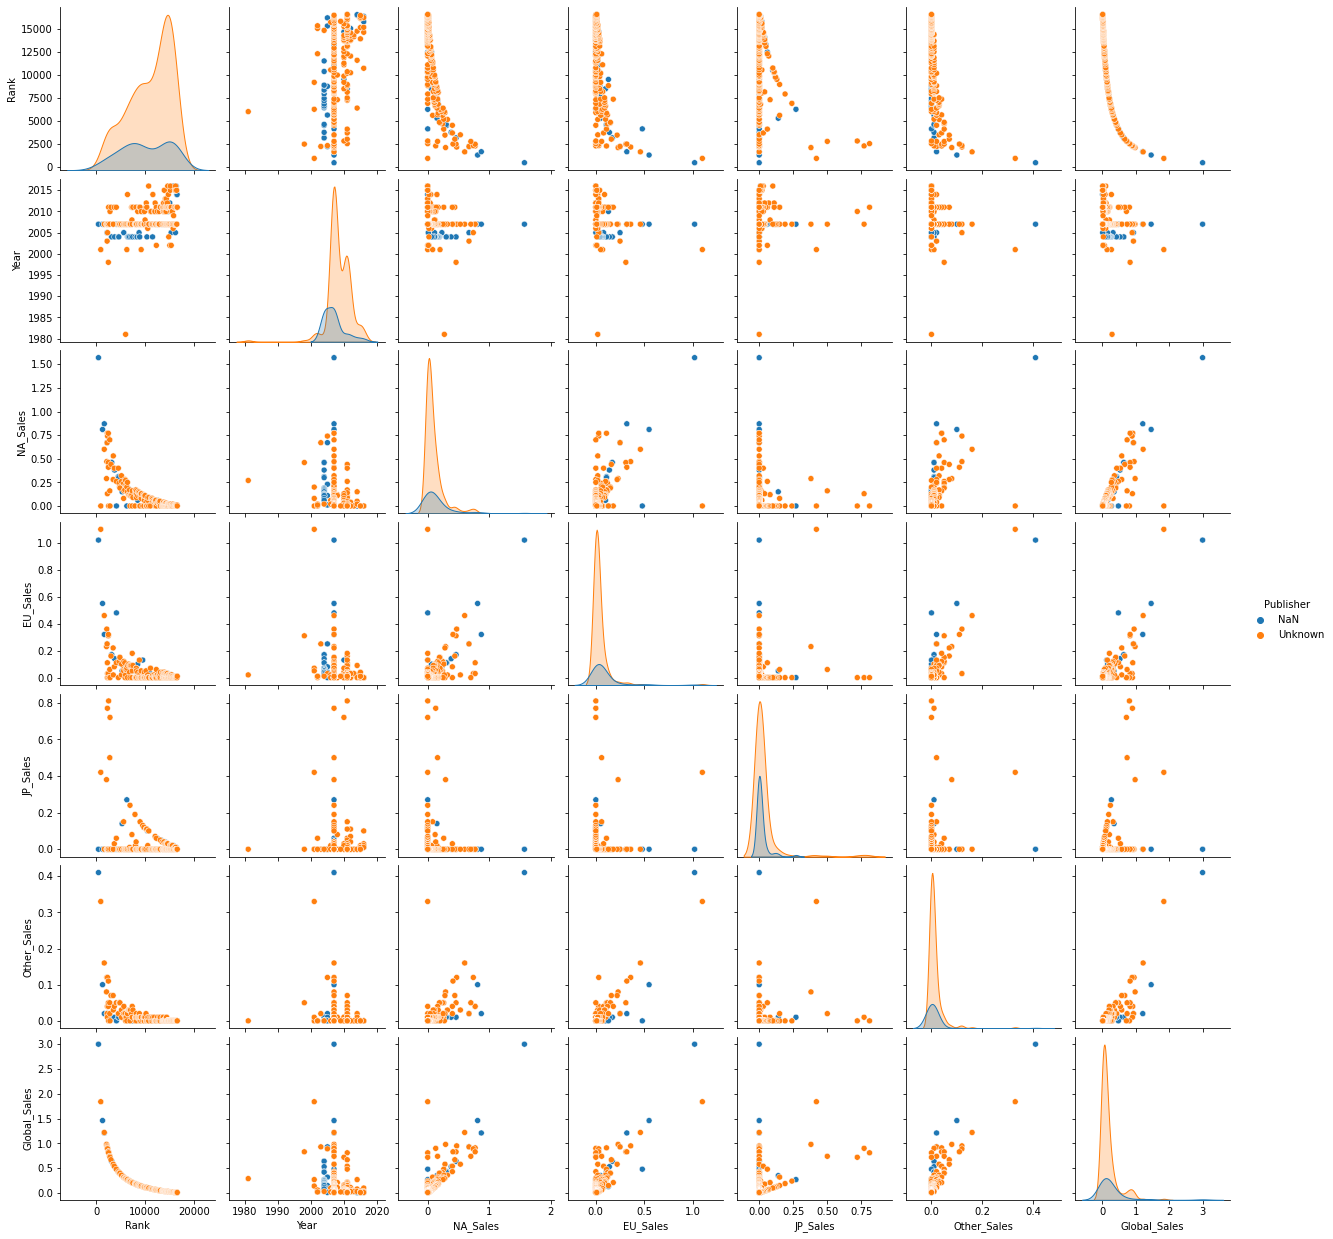

In [8]:
# Publisherの欠損とUnkownの分布の違いを確認
pub_nan_df = df[df['Publisher']=='NaN']
pub_unknown_df = df[df['Publisher']=='Unknown']
pub_missing_df = pd.concat([pub_nan_df, pub_unknown_df])
sns.pairplot(pub_missing_df, hue='Publisher')

In [9]:
# SimpleImputerでも欠損値代入が可能
# Yearに中央値，Publisherには最頻値を入れる例
df = pd.read_csv('vgsales.csv')
imputer = SimpleImputer(strategy='median')
df['Year'] = imputer.fit_transform(df[['Year']])
imputer = SimpleImputer(strategy='most_frequent')
df[['Publisher']] = imputer.fit_transform(df[['Publisher']])

In [10]:
# Platform別にYearの中央値を計算し，その値で欠損値を埋める
df = pd.read_csv('vgsales.csv')
platform_year_dict = df.groupby('Platform').median()['Year'].to_dict()
df['Year'] = df.apply(lambda row: platform_year_dict[row['Platform']] if np.isnan(row['Year']) and (row['Platform'] in platform_year_dict) else row['Year'], axis=1)

In [11]:
# それぞれのPlatformに対応してYearの値が入っている
df.iloc[year_na_idx]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
179,180,Madden NFL 2004,PS2,2005.0,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23
377,378,FIFA Soccer 2004,PS2,2005.0,Sports,Electronic Arts,0.59,2.36,0.04,0.51,3.49
431,432,LEGO Batman: The Videogame,Wii,2009.0,Action,Warner Bros. Interactive Entertainment,1.86,1.02,0.00,0.29,3.17
470,471,wwe Smackdown vs. Raw 2006,PS2,2005.0,Fighting,NaN,1.57,1.02,0.00,0.41,3.00
607,608,Space Invaders,2600,1982.0,Shooter,Atari,2.36,0.14,0.00,0.03,2.53
...,...,...,...,...,...,...,...,...,...,...,...
16307,16310,Freaky Flyers,GC,2003.0,Racing,Unknown,0.01,0.00,0.00,0.00,0.01
16327,16330,Inversion,PC,2009.0,Shooter,Namco Bandai Games,0.01,0.00,0.00,0.00,0.01
16366,16369,Hakuouki: Shinsengumi Kitan,PS3,2011.0,Adventure,Unknown,0.01,0.00,0.00,0.00,0.01
16427,16430,Virtua Quest,GC,2003.0,Role-Playing,Unknown,0.01,0.00,0.00,0.00,0.01


In [12]:
# 代表値による欠損代入する場合，代表値は学習データを使用して計算する
df = pd.read_csv('vgsales.csv')
# 今回は'JP_Sales' を予測するタスクとする
df.drop('Global_Sales', inplace=True, axis=1) # Global_Salesがあると簡単にJP_Salesを計算できてしまうため
target = 'JP_Sales'
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
platform_year_dict = X_train.groupby('Platform').median()['Year'].to_dict()
X_train['Year'] = X_train.apply(lambda row: platform_year_dict[row['Platform']] if np.isnan(row['Year']) and (row['Platform'] in platform_year_dict) else row['Year'], axis=1)

In [13]:

# テストデータにも同様にplatform_year_dictを使用する
X_test['Year'] = X_test.apply(lambda row: platform_year_dict[row['Platform']] if np.isnan(row['Year']) and (row['Platform'] in platform_year_dict) else row['Year'], axis=1)

In [14]:
X_test

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,Other_Sales
1586,1588,Tom Clancy's Rainbow Six: Vegas,PS3,2007.0,Shooter,Ubisoft,0.47,0.53,0.22
5368,5370,Monster Rancher 4,PS2,2003.0,Simulation,Tecmo Koei,0.08,0.06,0.02
6275,6277,Dynasty Warriors,PS,1997.0,Action,Tecmo Koei,0.09,0.06,0.02
9130,9132,Bravo Air Race,PS,1997.0,Racing,THQ,0.08,0.05,0.01
5759,5761,Football Manager 2016,PC,2015.0,Simulation,Sega,0.00,0.29,0.02
...,...,...,...,...,...,...,...,...,...
6020,6022,FIFA Soccer 13,3DS,2012.0,Action,Electronic Arts,0.06,0.20,0.03
1643,1645,Chocobo no Fushigi Dungeon,PS,1997.0,Role-Playing,SquareSoft,0.00,0.00,0.08
4002,4004,Super Famista 5,SNES,1996.0,Sports,Namco Bandai Games,0.00,0.00,0.00
7259,7261,Pinball Hall of Fame: The Williams Collection,PS3,2009.0,Misc,Crave Entertainment,0.20,0.00,0.02


### kNNで欠損値代入

In [15]:
# データ準備
df = pd.read_csv('vgsales.csv')
df[['Publisher']] = df[['Publisher']].fillna('NaN')
df.drop("Name", axis=1, inplace=True)
# Yearカラムの欠損をKNNで代入する
target = "Year"
X = df.drop(target, axis=1)
y = df[target]
# 数値カラムのリスト取得(標準化の対象)
num_cols = X.select_dtypes(include=np.number).columns.to_list()
# ダミー変数
X = pd.get_dummies(X, drop_first=True)
# 標準化
X[num_cols] = StandardScaler().fit_transform(X[num_cols])
# YearがNaNのデータはテストデータ，そうでなければ学習データ
test_indexes = df[df['Year'].isna()].index
train_indexes = df[~df['Year'].isna()].index
X_train, X_test = X.iloc[train_indexes], X.iloc[test_indexes]
y_train, y_test = y.iloc[train_indexes], y.iloc[test_indexes]

In [16]:
# kNNのモデルを作って予測値を代入する
knn = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)
y_pred = knn.predict(X_test)